<a href="https://colab.research.google.com/github/aswinselvakumar/Digital-Image-Recognizer-Using-MNIST-Database-and-Preconditioning-Techniques/blob/main/ML_Project_Digital_Image_Recognizer_Using_MNIST_Database_and_Preconditioning_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Standard Analysis

In [ ]:

import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/drive',force_remount=True)
file_path = '/content/sample_data/mnist_train_small.csv'
df = pd.read_csv(file_path)

print(df.head())
print(df.info())
print(df.describe())
print(df.columns)
print(df.dtypes)
mean_values = df.mean()


median_values = df.median()


mode_values = df.mode().iloc[0]


std_dev_values = df.std()


print("Mean values:\n", mean_values)
print("\nMedian values:\n", median_values)
print("\nMode values:\n", mode_values)
print("\nStandard Deviation values:\n", std_dev_values)

Mounted at /content/drive
   6  0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  ...  0.581  0.582  0.583  \
0  5  0    0    0    0    0    0    0    0    0  ...      0      0      0   
1  7  0    0    0    0    0    0    0    0    0  ...      0      0      0   
2  9  0    0    0    0    0    0    0    0    0  ...      0      0      0   
3  5  0    0    0    0    0    0    0    0    0  ...      0      0      0   
4  2  0    0    0    0    0    0    0    0    0  ...      0      0      0   

   0.584  0.585  0.586  0.587  0.588  0.589  0.590  
0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0  

[5 rows x 785 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19999 entries, 0 to 19998
Columns: 785 entries, 6 to 0.590
dtypes: int64(785)
memory usage: 119.8 MB
None
             

Bayesian Logistic Regression



In [ ]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np

# Step 1: Load data
file_path = '/content/sample_data/mnist_train_small.csv'
df = pd.read_csv(file_path)

# Step 2: Separate features and labels
X = df.iloc[:, 1:].values  # Features (pixels)
y = df.iloc[:, 0].values   # Labels (digits)

# For simplicity, let's focus on binary classification (e.g., 0 and 1)
binary_filter = np.isin(y, [0, 1])
X_binary = X[binary_filter]
y_binary = y[binary_filter]

# Step 3: Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_binary)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float)
y_tensor = torch.tensor(y_binary, dtype=torch.float)

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Step 5: Define the Bayesian Logistic Regression model in Pyro
def model(X, y=None):
    # Priors for weights and intercept
    weights = pyro.sample('weights', dist.Normal(torch.zeros(X.shape[1]), torch.ones(X.shape[1])).to_event(1))
    intercept = pyro.sample('intercept', dist.Normal(torch.tensor(0.), torch.tensor(10.)))

    # Linear combination (logits)
    logits = torch.matmul(X, weights) + intercept

    # Likelihood (Bernoulli likelihood with logits for binary classification)
    with pyro.plate('data', X.shape[0]):
        pyro.sample('obs', dist.Bernoulli(logits=logits), obs=y)

# Step 6: Define the guide (variational distribution for inference)
def guide(X, y=None):
    # Variational parameters for weights
    weights_loc = pyro.param('weights_loc', torch.zeros(X.shape[1]))
    weights_scale = pyro.param('weights_scale', torch.ones(X.shape[1]), constraint=dist.constraints.positive)

    # Variational parameters for intercept
    intercept_loc = pyro.param('intercept_loc', torch.tensor(0.))
    intercept_scale = pyro.param('intercept_scale', torch.tensor(1.), constraint=dist.constraints.positive)

    # Sample from the variational distribution (approximate posterior)
    pyro.sample('weights', dist.Normal(weights_loc, weights_scale).to_event(1))
    pyro.sample('intercept', dist.Normal(intercept_loc, intercept_scale))

# Step 7: Set up the optimizer and inference method (Stochastic Variational Inference)
adam = Adam({"lr": 0.01})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

# Step 8: Train the model (run inference)
num_steps = 5000  # Number of steps to run the optimizer
for step in range(num_steps):
    loss = svi.step(X_train, y_train)
    if step % 500 == 0:
        print(f"Step {step} : loss = {loss}")

# Step 9: Get the learned parameters from the variational distribution
weights_loc = pyro.param('weights_loc').detach().numpy()
intercept_loc = pyro.param('intercept_loc').item()

# Step 10: Make predictions on the test set
with torch.no_grad():
    logits_test = torch.matmul(X_test, torch.tensor(weights_loc)) + intercept_loc
    y_pred_prob = torch.sigmoid(logits_test).numpy()

# Step 11: Convert probabilities to binary predictions
y_pred = (y_pred_prob > 0.5).astype(int)

# Step 12: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Detailed classification report
print(classification_report(y_test, y_pred))


Step 0 : loss = 14812.42036730051
Step 500 : loss = 200.44628649950027
Step 1000 : loss = 182.96375226974487
Step 1500 : loss = 198.60208249092102
Step 2000 : loss = 147.3741476535797
Step 2500 : loss = 140.80603671073914
Step 3000 : loss = 205.14939975738525
Step 3500 : loss = 161.67535531520844
Step 4000 : loss = 168.5826414823532
Step 4500 : loss = 114.49460661411285
Accuracy: 99.52%
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       397
         1.0       1.00      0.99      1.00       444

    accuracy                           1.00       841
   macro avg       1.00      1.00      1.00       841
weighted avg       1.00      1.00      1.00       841



Linear Regression

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Step 1: Load the data (MNIST dataset as an example)
file_path = '/content/sample_data/mnist_train_small.csv'
df = pd.read_csv(file_path)

# Use one column (for simplicity, we'll predict the first pixel value in the image) as the target.
# Normally in linear regression, you'd use real continuous data, but for illustration, let's predict pixel[0].
X = df.iloc[:, 1:].values  # Features (pixels)
y = df.iloc[:, 1].values   # Let's predict the value of the first pixel

# Step 2: Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # Add an extra dimension for target

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Step 4: Define a simple Linear Regression model using PyTorch
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LinearRegressionModel, self).__init__()
        # Single linear layer: input_dim -> 1 (for one output, which is the predicted value)
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x)

# Initialize the model
input_dim = X_train.shape[1]  # Number of input features (pixels)
model = LinearRegressionModel(input_dim)

# Step 5: Define the loss function (Mean Squared Error) and the optimizer (Stochastic Gradient Descent)
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.SGD(model.parameters(), lr=0.01)  # Stochastic Gradient Descent

# Step 6: Train the model
num_epochs = 1000  # Number of training epochs
for epoch in range(num_epochs):
    model.train()  # Set model to training mode

    # Forward pass: Compute predicted y by passing X_train to the model
    y_pred = model(X_train)

    # Compute the loss
    loss = criterion(y_pred, y_train)

    # Backward pass: Compute gradients
    optimizer.zero_grad()  # Zero the gradients before running the backward pass
    loss.backward()        # Backpropagate the loss

    # Update the weights
    optimizer.step()       # Perform one optimization step

    if (epoch+1) % 100 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

# Step 7: Evaluate the model
model.eval()  # Set model to evaluation mode

# Make predictions on the test set
with torch.no_grad():
    y_pred_test = model(X_test)
    y_pred_test = y_pred_test.detach().numpy()

# Step 8: Calculate evaluation metrics
y_test_np = y_test.numpy()
mse = mean_squared_error(y_test_np, y_pred_test)
r2 = r2_score(y_test_np, y_pred_test)

print(f'Mean Squared Error: {mse:.4f}')
print(f'R-squared: {r2:.4f}')


Epoch 100/1000, Loss: 0.0120
Epoch 200/1000, Loss: 0.0062
Epoch 300/1000, Loss: 0.0041
Epoch 400/1000, Loss: 0.0029
Epoch 500/1000, Loss: 0.0022
Epoch 600/1000, Loss: 0.0017
Epoch 700/1000, Loss: 0.0014
Epoch 800/1000, Loss: 0.0011
Epoch 900/1000, Loss: 0.0009
Epoch 1000/1000, Loss: 0.0008
Mean Squared Error: 0.0153
R-squared: 0.0000


SVM Classifier

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Step 1: Load data
file_path = '/content/sample_data/mnist_train_small.csv'
df = pd.read_csv(file_path)

# Step 2: Separate features and labels
X = df.iloc[:, 1:].values  # Features (pixels)
y = df.iloc[:, 0].values   # Labels (digits)

# Step 3: Normalize the data (optional but recommended for SVM)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 5: Train the SVM classifier
svm_model = SVC(kernel='rbf')  # You can try 'rbf', 'poly' for different kernels
svm_model.fit(X_train, y_train)

# Step 6: Make predictions
y_pred = svm_model.predict(X_test)

# Step 7: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Detailed classification report
print(classification_report(y_test, y_pred))


Accuracy: 94.75%
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       377
           1       0.97      0.98      0.98       436
           2       0.89      0.95      0.92       390
           3       0.94      0.94      0.94       406
           4       0.93      0.96      0.94       401
           5       0.95      0.93      0.94       341
           6       0.98      0.98      0.98       412
           7       0.95      0.92      0.93       438
           8       0.94      0.95      0.94       384
           9       0.95      0.90      0.93       415

    accuracy                           0.95      4000
   macro avg       0.95      0.95      0.95      4000
weighted avg       0.95      0.95      0.95      4000



Principal Componenent Analysis(PCA) Of MNIST DATA

Explained Variance Ratio: [0.0590205  0.04282781]


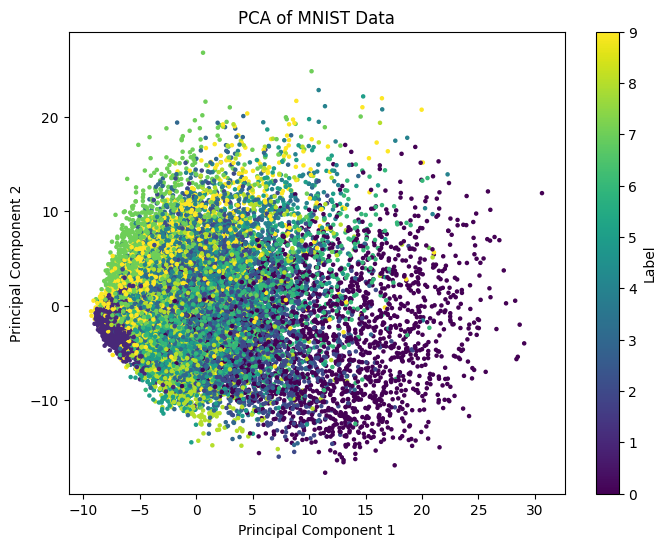

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/sample_data/mnist_train_small.csv'
df = pd.read_csv(file_path)

# Separate the features (assuming the first column is labels)
X = df.iloc[:, 1:].values  # features
y = df.iloc[:, 0].values   # labels (if needed)

# Standardize the data (PCA is sensitive to the scale of the data)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=2)  # Change n_components to reduce dimensions as needed
X_pca = pca.fit_transform(X_scaled)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance Ratio: {explained_variance}")

# Plot the PCA result
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', s=5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of MNIST Data')
plt.colorbar(label='Label')
plt.show()


K-Means Clustering of MNIST Data


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


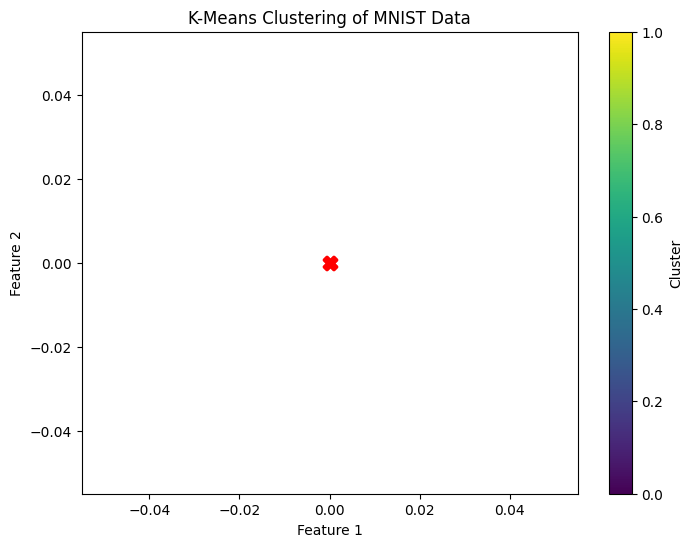

Inertia: 11631406.550904281


In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/sample_data/mnist_train_small.csv'
df = pd.read_csv(file_path)

# Separate the features (assuming the first column is labels)
X = df.iloc[:, 1:].values  # features (pixels)
y = df.iloc[:, 0].values   # labels (if needed)

# Standardize the data (K-Means is sensitive to the scale of the data)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-Means clustering
kmeans = KMeans(n_clusters=10, random_state=42)  # Set number of clusters to 10
kmeans.fit(X_scaled)

# Get the cluster labels and centroids
cluster_labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Visualize the results using the first two features (or use PCA for dimensionality reduction)
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=cluster_labels, cmap='viridis', s=5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=100, marker='X')  # Plot centroids
plt.title('K-Means Clustering of MNIST Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster')
plt.show()

# Optional: evaluate the clustering performance using inertia (sum of squared distances)
print(f"Inertia: {kmeans.inertia_}")


 Hierarchical Clustering


Mounted at /content/drive


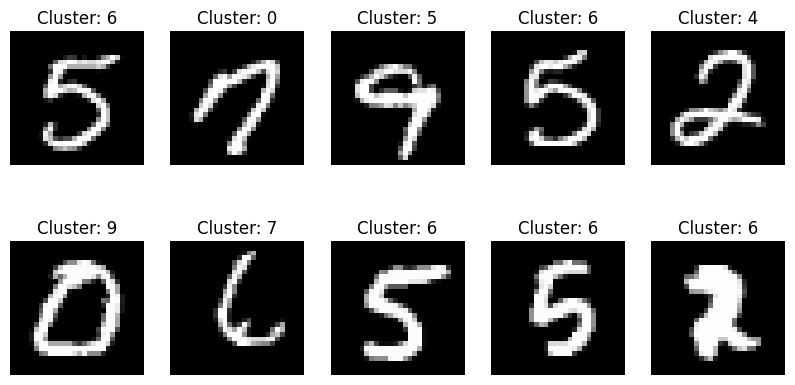

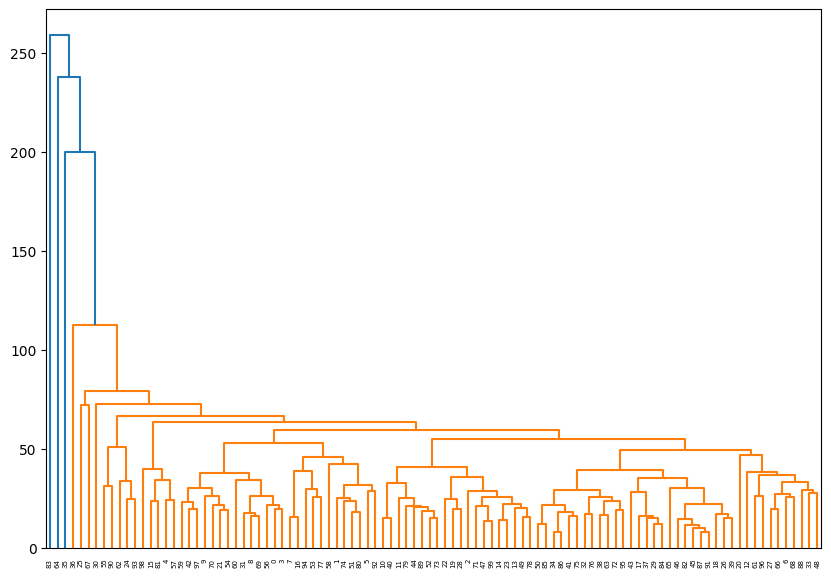

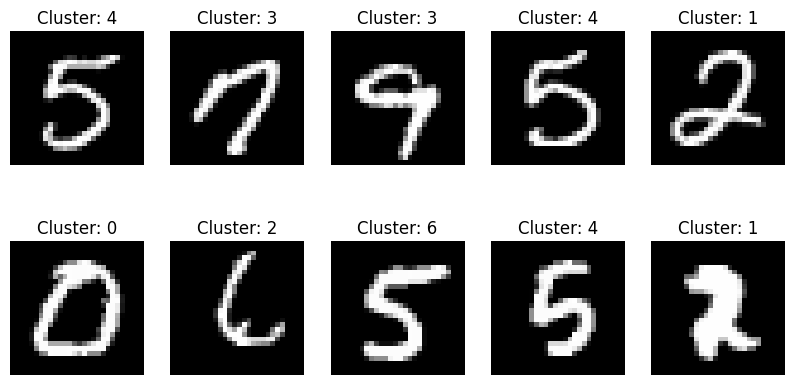

GMM Confusion Matrix:
 [[   6    8   33   54   84    2  160   96    1 1518]
 [  17    1   16 2048   38   21   63   37    0    2]
 [   9   26  841   49  541   15  334  141    6   27]
 [  53   25   64  226  326   80 1149   43   21   34]
 [ 203  226   22  170  106  995  109   49    2   42]
 [ 624   56   28  148  203   68  566   34    0   34]
 [   4    1  290  137   49    0   36 1472    0   49]
 [ 470   45    2   87    5 1139   40    0  328   10]
 [ 301   59   25  551   62  159  710    9    3   33]
 [ 205  211    5  284    6 1267   35    0    1    9]]
Hierarchical Clustering Confusion Matrix:
 [[1688   50   19    6    9    1  178    2    8    1]
 [   1   17   10   19   25 2160    7    0    0    4]
 [  17 1489   26   52  113    3   40   31  205   13]
 [   3  102    3  129 1473    4   37   30  229   11]
 [   2   51   12 1594    8    2   50   77    4  124]
 [  23   16   22   67  594    0  997   17   20    5]
 [  35  518 1390    8   23    3   61    0    0    0]
 [   1   12    0 1094   24    6 

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

# Mount Google Drive and load the dataset
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

file_path = '/content/sample_data/mnist_train_small.csv'
df = pd.read_csv(file_path)

# Data Preprocessing
# Assuming the first column is the labels and the rest are pixel values
X = df.drop(columns=[df.columns[0]])  # Dropping the label column
y = df[df.columns[0]]  # Labels (if needed for validation)

# Normalize the data (important for clustering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---------------------- Gaussian Mixture Model (GMM) ----------------------

# Define and train the GMM model
gmm = GaussianMixture(n_components=10, random_state=42)  # 10 for 10 digits
gmm.fit(X_scaled)

# Predict the cluster for each data point
gmm_labels = gmm.predict(X_scaled)

# Plot a few examples and their corresponding GMM cluster
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X.iloc[i].values.reshape(28, 28), cmap='gray')
    plt.title(f'Cluster: {gmm_labels[i]}')
    plt.axis('off')
plt.show()

# ------------------- Hierarchical Clustering -----------------------------

# Perform hierarchical clustering
hierarchical_clustering = AgglomerativeClustering(n_clusters=10)
hierarchical_labels = hierarchical_clustering.fit_predict(X_scaled)

# Plot dendrogram (subset of 100 samples for better visualization)
Z = linkage(X_scaled[:100], 'ward')
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.show()

# Plot a few examples and their corresponding Hierarchical cluster
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X.iloc[i].values.reshape(28, 28), cmap='gray')
    plt.title(f'Cluster: {hierarchical_labels[i]}')
    plt.axis('off')
plt.show()

# ------------------- Evaluation (Optional) -------------------------------

# GMM Accuracy and Confusion Matrix (optional)
print("GMM Confusion Matrix:\n", confusion_matrix(y, gmm_labels))

# Hierarchical Clustering Accuracy and Confusion Matrix (optional)
print("Hierarchical Clustering Confusion Matrix:\n", confusion_matrix(y, hierarchical_labels))


Mathematical Modelling


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Load the dataset
file_path = '/content/sample_data/mnist_train_small.csv'
df = pd.read_csv(file_path)

# Splitting the data into features (X) and labels (y)
X = df.drop('6', axis=1).values  # Assuming '6' is the label column
y = df['6'].values

# Normalize the features (scale pixel values to [0, 1])
X = X / 255.0

# One-hot encode the labels
lb = LabelBinarizer()
y = lb.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Building the neural network model
model = Sequential([
    Flatten(input_shape=(X_train.shape[1],)),  # Flatten input images
    Dense(128, activation='relu'),  # Hidden layer
    Dense(10, activation='softmax')  # Output layer for 10 classes (digits 0-9)
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',S
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)

print(f'Test accuracy: {test_acc}')

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8029 - loss: 0.6973 - val_accuracy: 0.9227 - val_loss: 0.2742
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9310 - loss: 0.2312 - val_accuracy: 0.9423 - val_loss: 0.2098
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9534 - loss: 0.1567 - val_accuracy: 0.9455 - val_loss: 0.1829
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9659 - loss: 0.1193 - val_accuracy: 0.9540 - val_loss: 0.1610
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9761 - loss: 0.0877 - val_accuracy: 0.9585 - val_loss: 0.1391
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9801 - loss: 0.0714 - val_accuracy: 0.9545 - val_loss: 0.1462
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9853 - loss: 0.0574 - val_accuracy: 0.9600 - val_loss: 0.1276
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9903 - loss: 0.0415 - val_accuracy: 0.

HMM Model Prediction

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from google.colab import drive
from hmmlearn import hmm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.exceptions import ConvergenceWarning
import warnings

# Ignore warnings related to convergence
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Mount Google Drive to access data
drive.mount('/content/drive', force_remount=True)

# Load data
file_path = '/content/sample_data/mnist_train_small.csv'
df = pd.read_csv(file_path)

# Separate features (pixels) and labels (digits)
X = df.drop('6', axis=1).values  # Drop the first column ('6'), which contains the labels
y = df['6'].values  # The first column is the label

# Normalize the data (scale pixel values)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce dimensionality using PCA
pca = PCA(n_components=50)  # Reduce dimensions to 50 components
X_reduced = pca.fit_transform(X_scaled)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42)

# Reshape data for HMM: Assume each image is a sequence of rows
# Reshape based on reduced PCA components, 50 in this case
sequence_length = 5  # Adjust based on new dimensionality, 50 PCA components can be reshaped as 5x10
X_train_reshaped = [X_train[i].reshape(sequence_length, -1) for i in range(X_train.shape[0])]
X_train_concat = np.concatenate(X_train_reshaped)

# Create correct lengths array
lengths = [sequence_length] * len(X_train_reshaped)

# Define and train an HMM model with adjusted parameters
model = hmm.GaussianHMM(n_components=3, covariance_type="diag", n_iter=1000, tol=0.01, random_state=42)

# Fit the model to the training data
model.fit(X_train_concat, lengths)

# Test the model on a test image sequence
test_image = X_test[0].reshape(sequence_length, -1)  # Reshape a test image into the correct sequence length
hidden_states = model.predict(test_image)

# Output the predicted hidden states for the test image
print("Predicted hidden states for the test image:", hidden_states)

# Calculate and print the log probability of the test image sequence
logprob = model.score(test_image)
print("Log probability of the test image sequence:", logprob)


Mounted at /content/drive
Predicted hidden states for the test image: [1 1 1 1 1]
Log probability of the test image sequence: -164.0177306176328


Generalized Additive Models


Accuracy: 89.60%


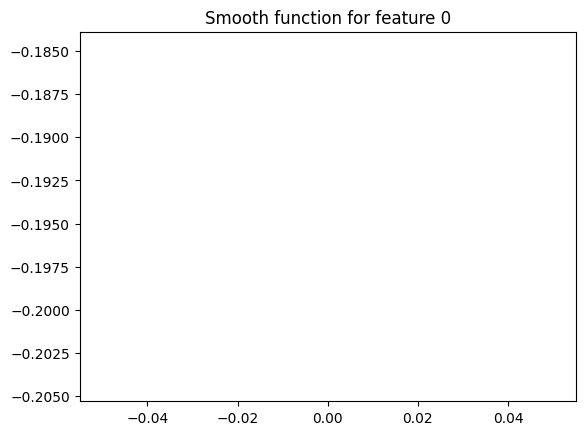

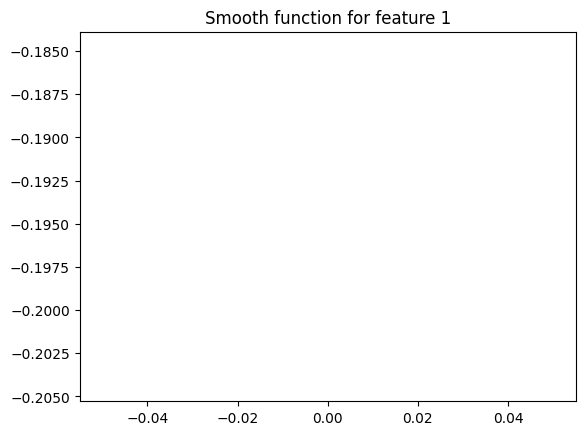

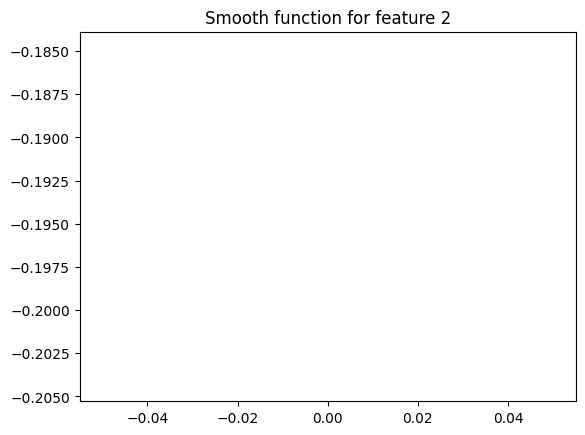

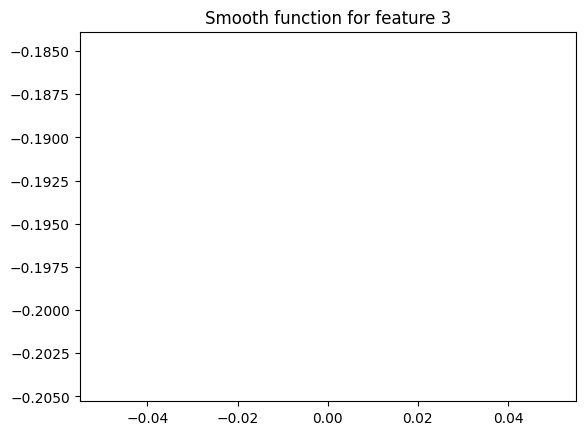

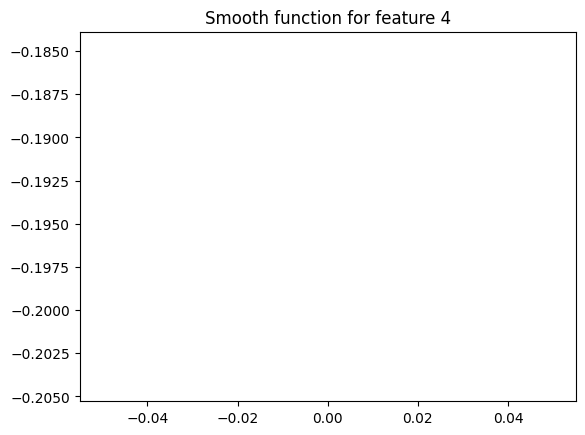

In [ ]:
import pandas as pd
import numpy as np
from pygam import LogisticGAM, s
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load the dataset
file_path = '/content/sample_data/mnist_train_small.csv'
df = pd.read_csv(file_path)

# Separate features (X) and target (y)
X = df.iloc[:, 1:]  # Features (pixel values)
y = df.iloc[:, 0]   # Target (digit labels)

# Convert multi-class labels to binary labels: Let's classify "3" vs. all other digits
y_binary = np.where(y == 3, 1, 0)  # 1 for digit "3", 0 for all other digits

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.3, random_state=42)

# Create a Generalized Additive Model for binary classification
gam = LogisticGAM(s(0) + s(1) + s(2) + s(3) + s(4))  # Using the first few features for simplicity

# Train the GAM model
gam.fit(X_train, y_train)

# Make predictions
y_pred = gam.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Visualize smooth functions for the first few features
import matplotlib.pyplot as plt
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    XX = gam.generate_X_grid(term=i)
    plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    plt.title(f'Smooth function for feature {i}')
    plt.show()
